In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib inline

#Setting constants 
ep_0 = 8.8541878*(10**(-12))
mew_0 = 4*(np.pi)*(10**(-7))
c0 = 299792458

In [2]:
def FDTD(z_axis, t_axis, Hs, Es, mew_r, ep_r, σ): 
    """
    Args:
        z_axis: Numpy array of linearly spaced points on z axis
        t_axis: Numpy array of linearly spaced time values
        Hs:     Numpy array over time axis of Magnetic Field due to source 
        Es:     Numpy array over time axis of Electric Field due to source 
        mew_r:  Numpy array over z_axis of relative permeability at that point
        ep_r:   Numpy array over z_axis of relative permittivity at that point
        σ:      Numpy array over z_axis of electrical conductance at that point
    
    Returns:
        EOverTime: Numpy array of E field values over z-axis over time 
        HOverTime: Numpy array of E field values over z-axis over time 
        
        such that EOverTime[t][z] gives Electric field value at time t and position z (t and z are indexs for t_axis and z_axis respectively)
    
    Perfectly Absorbing Boundary conditions are applied 
    Loss is introduced becuase of the presence of electrical conductance, σ (can be set to zero for simulation wothout loss)  
    """
    z_steps = z_axis.size
    t_steps = t_axis.size
    
    #Update Coefficients for fdtd 
    mHx = mEy1 = mEy2 = np.ones(z_steps)

    mHx = dt*c0/(mew_r*dz)

    mEy1 = (2*ep_0*ep_r - σ*dt)/(2*ep_0*ep_r + σ*dt)
    mEy2 = 2*ep_0*c0*dt/(dz*(2*ep_0*ep_r + dt*σ))
    
    HxOverTime = EyOverTime = np.zeros((1, z_steps))
    
    #Electric and Magentic field values are stored up to 2 spaces (e1,e2,h1,h2) beyond the axis to apply perfectly absorbing boundaries
    h2 = h1 = e2 = e1 = 0
    
    for t in range(1,t_steps,1):
        
        HxOverTime[t-1][2] -= mHx[2]*Es[t-1]
        EyOverTime[t-1][3] = mEy1[3]*EyOverTime[t-1][3] - mEy2[3]*Hs[t-1]
        
        Hx = HxOverTime[t-1]
        Ey = EyOverTime[t-1]
        
        h2 = h1
        h1 = Hx[0]
        
        Hx[:z_steps-1] += mHx[:z_steps-1]*(Ey[1:]-Ey[:z_steps-1])
        Hx[z_steps-1] += mHx[z_steps-1]*(e2-Ey[z_steps-1])
        
        HxOverTime = np.append(HxOverTime, np.array([Hx]), axis=0)
        
        e2 = e1
        e1 = Ey[z_steps-1]
        
        Ey[0] = mEy1[0]*Ey[0] + mEy2[0]*(Hx[0]- h2)
        Ey[1:] = mEy1[1:]*Ey[1:] + mEy2[1:]*(Hx[1:]-Hx[:z_steps-1])   
        
        EyOverTime = np.append(EyOverTime, np.array([Ey]), axis=0)
    
    return HxOverTime, EyOverTime

In [3]:
#Grid Resolution
dz = 0.001

#Grid Size
z_steps = 100
z_len = (z_steps-1)*dz
z_axis = np.linspace(0,z_len, z_steps)

#Setting environment parameters
mew_r = ep_r = n = np.ones(z_steps)
mew_r[int(z_steps/2):-4] = 2.0
ep_r[int(z_steps/2):-4]  = 2.0
n = np.sqrt(mew_r*ep_r)

σ = np.zeros(z_steps)
σ[int(z_steps/2):-4] = 10**(-1)
    
#Time Step
dt = dz/(2*c0)    #dt is chosen to be dz/2*c0 so that the magnitude of c0*dt and dx have the same order of magnitude and the wave travels 1 grid point in 2 time steps for the implementation of perfectly absorbing coundary conditions

#Time Period
t_steps = 700
timePeriod = (t_steps-1)*dt
t_axis = np.linspace(0, timePeriod, t_steps)

In [4]:
#Gaussian source (impulse)
def Esrc(t, t0, tau):
    return np.exp(-((t-t0)/tau)**2) 

def Hsrc(t, t0, tau, A):
    return A*np.exp(-((t-t0+3*dt/2)/tau)**2 )

#Source Parameters
tau = 20*dt
t0  = 6*tau

A = -np.sqrt(2.0/2.0) #Normalizing Magnetic Field so it has the same order of magnitude as electric field

#Generating Electric and Magnetic Field due to source over time
Es = Esrc(t_axis, t0, tau)
Hs = Hsrc(t_axis, t0, tau, A)

In [5]:
#Running simulation
HOverTime, EOverTime = FDTD(z_axis, t_axis, Hs, Es, mew_r, ep_r, σ)

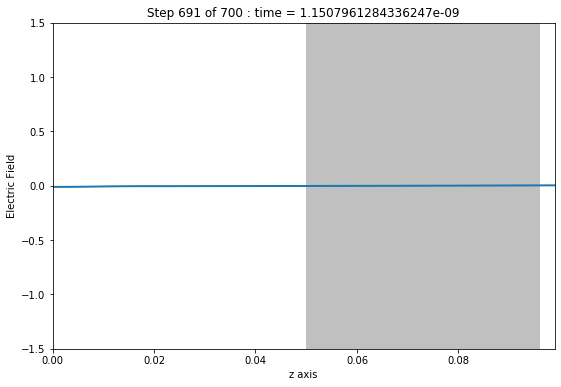

In [7]:
#Animation
fig = plt.figure(figsize=(9,6))
ax = plt.axes(xlim=(0, z_len), ylim = (-1.5,1.5))

#The region with different refractive index is colored silver
for i in range(0, z_steps, 1):
    if n[i] == 1.0:
        plt.axvspan(i*dz, (i+1)*dz, facecolor='w')
    else:
        plt.axvspan(i*dz, (i+1)*dz, facecolor='silver')

ax.set_xlabel('z axis')
ax.set_ylabel('Electric Field')

line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

#The E field over z acis is plotted every 10th time step
def animate(t):
    x = z_axis
    y = EOverTime[10*t]
    plt.title("Step " + str(10*t+1) + " of " + str(t_steps)+ " : time = " + str(10*t*dt))
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=int(t_steps/10), interval=1, blit=True)

anim.save("EOverZ.gif", writer='imagemagick')  